<a href="https://colab.research.google.com/github/andrevcmelo/Emiss-o-CO2/blob/master/emiss%C3%B5es_CO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   Link Fonte dos Dados: http://plataforma.seeg.eco.br/economic_activity
2.   Link Auxiliar sobre Emissões de gases poluentes: http://www.observatoriodoclima.eco.br/metodologia/
3.   Link Github com Dados em csv: https://raw.githubusercontent.com/andrevcmelo/test/master/emissao_co2_brasil.csv
4.   Link matérias: https://forbes.com.br/negocios/2020/07/casa-dos-ventos-e-grupo-moura-anunciam-parceria-para-autossuficiencia-em-energia-eolica/
5.   Link matérias: https://exame.com/negocios/microsoft-nike-e-natura-formam-consorcio-para-zerar-emissoes-de-carbono/
https://wribrasil.org.br/pt/blog/2019/04/ranking-paises-que-mais-emitem-carbono-gases-de-efeito-estufa-aquecimento-global
https://www.bbc.com/portuguese/brasil-50811386





In [469]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE

In [470]:
data = pd.read_csv("https://raw.githubusercontent.com/andrevcmelo/test/master/emissao_co2_brasil.csv",sep=';', quotechar='"',encoding='iso-8859-1')

In [471]:
data.head()
#Identificamos que o formato dos dados não estão favoráveis para análise, visto que os anos estão em colunas.

,Categoria,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Agricultura,19009740,18533743,20655431,20794861,21949714,22278086,22496768,24424471,24338238,26731689,28547016,26081621,26830058,27022114,29904905,30532872,28931303,30607148,31115225,31331221,29091937,30928259,32864341,34165367,36379823,36586914,34502695,35063696,36139329,37540691,38581564,38903161,41119087,45650907,46996616,46237497,47069209,51460189,52920481,53460890,56173063,61751635,59996909,63538088,65741523,64294209,68759433,71573622,70222653
1,Agricultura e/ou Agropecuária,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Agropecuária,3332108,3737844,4310490,5050807,5335352,5660269,6227105,6763432,6804973,7859832,8825783,8595867,8801218,9243919,9481245,10751184,10593440,11435878,11864534,12449608,1135645229,973645061,1136852084,1204615021,1205782326,2089378545,1449118402,1162352235,1403765755,1396838098,1454817257,1859384587,2098910704,2890734676,3075681747,2092934470,1701520739,1431812827,1530276799,937546118,978580658,914540828,787576188,990442005,815174932,911477831,927329882,833576914,862542076
3,Cimento,7760596,8399270,9595554,10963722,12213525,13351836,15661336,17048993,18494451,19048122,19538018,19124493,18979446,14538293,12620480,13534535,16587047,17125150,16821734,16704224,16941306,18401179,14954768,15356804,15212504,17558096,20953850,23572756,25229296,26352110,26299866,25963815,24399950,21629149,21074144,23144753,24984262,27891474,30785765,31849080,35446325,39553736,41340972,42395890,41809588,38184572,34886736,32287119,31420279
4,Comercial,688385,730951,804091,859027,913738,965083,1036875,1072597,1117604,1202351,1292000,1357749,1348635,1246729,950308,1067087,1269378,1301684,1600788,1885290,2214022,2066631,2113484,1685126,1699234,1691964,1736028,1839559,1957809,2082380,2314400,2430759,2695104,1986275,2128273,1999931,2061407,2096944,1892461,1470669,1562350,1582966,1826969,1722452,1804074,1535757,1558829,1472672,1534689


# Pré Processamento dos Dados

In [472]:
#Transformando os dados das colunas em linhas
dados = data.melt(id_vars=['Categoria'], var_name = 'Data', value_name = 'Valor').sort_values(by=['Categoria','Data']).reset_index(drop=True)
#Setando index em Data

In [473]:
dados.head()

,Categoria,Data,Valor
0,Agricultura,1970,19009740
1,Agricultura,1971,18533743
2,Agricultura,1972,20655431
3,Agricultura,1973,20794861
4,Agricultura,1974,21949714


In [474]:
#Quantidade de valores em branco
print(dados.isna().sum())
print('\n')
#Resumo dos tipos dos dados do dataset
print(dados.dtypes)
print('\n')
#Quantidade de linhas vs Quantidade de colunas do dataset
print(dados.shape)

Categoria    0
Data         0
Valor        0
dtype: int64


Categoria    object
Data         object
Valor         int64
dtype: object


(931, 3)


In [475]:
#visualizar as categorias de atividade economica
dados.groupby('Categoria')['Data'].nunique()

Categoria
Agricultura                      49
Agricultura e/ou Agropecuária    49
Agropecuária                     49
Cimento                          49
Comercial                        49
Conservação                      49
Energia Elétrica                 49
Metalurgia                       49
Não alocado                      49
Outras Industrias                49
Pecuária                         49
Produção de Combustíveis         49
Público                          49
Residencial                      49
Saneamento Básico                49
Transporte                       49
Transporte de Carga              49
Transporte de Passageiro         49
Uso de HFCs                      49
Name: Data, dtype: int64

In [476]:
#Verificando as Categorias sem valores 
categoria_sem_valores = dados[dados['Valor']==0]
categoria_sem_valores.groupby('Categoria')['Data'].nunique()
#Resultado: 3 categorias possuem todos os anos sem dados, ou seja, não contibuirão para a análise

Categoria
Agricultura e/ou Agropecuária    49
Conservação                      49
Não alocado                      20
Transporte                       49
Uso de HFCs                      20
Name: Data, dtype: int64

In [477]:
categoria_sem_valores = categoria_sem_valores.groupby('Categoria')['Data'].nunique().reset_index()
print(categoria_sem_valores)

                       Categoria  Data
0  Agricultura e/ou Agropecuária    49
1                    Conservação    49
2                    Não alocado    20
3                     Transporte    49
4                    Uso de HFCs    20


In [478]:
#Separando as Categorias sem dados
categoria_sem_valores = categoria_sem_valores[categoria_sem_valores['Data'] == 49]
categoria_sem_valores

,Categoria,Data
0,Agricultura e/ou Agropecuária,49
1,Conservação,49
3,Transporte,49


In [479]:
#Criando uma lista com as categorias sem dados
lista_cat = categoria_sem_valores['Categoria'].tolist()
print(lista_cat)

['Agricultura e/ou Agropecuária', 'Conservação', 'Transporte']


In [480]:
#Removendo as categorias sem dados
for i in lista_cat:
  dados = dados[dados['Categoria'] != i]

In [481]:
print(dados.shape)

(784, 3)


In [482]:
#Validando que não existem categorias sem dados
categoria_sem_valores = dados[dados['Valor']==0]
categoria_sem_valores.groupby('Categoria')['Data'].nunique()

Categoria
Não alocado    20
Uso de HFCs    20
Name: Data, dtype: int64

In [483]:
#valor de CO2 em milhões de toneladas
dados['Valor/mi_t'] = round(dados['Valor']/1000000,2)

In [484]:
dados

,Categoria,Data,Valor,Valor/mi_t
0,Agricultura,1970,19009740,19.01
1,Agricultura,1971,18533743,18.53
2,Agricultura,1972,20655431,20.66
3,Agricultura,1973,20794861,20.79
4,Agricultura,1974,21949714,21.95
...,...,...,...,...
926,Uso de HFCs,2014,14480904,14.48
927,Uso de HFCs,2015,15383099,15.38
928,Uso de HFCs,2016,16285293,16.29
929,Uso de HFCs,2017,17187487,17.19


In [485]:
dados.groupby('Categoria')['Data'].nunique()

Categoria
Agricultura                 49
Agropecuária                49
Cimento                     49
Comercial                   49
Energia Elétrica            49
Metalurgia                  49
Não alocado                 49
Outras Industrias           49
Pecuária                    49
Produção de Combustíveis    49
Público                     49
Residencial                 49
Saneamento Básico           49
Transporte de Carga         49
Transporte de Passageiro    49
Uso de HFCs                 49
Name: Data, dtype: int64

In [486]:
#Criando DataFrame para trabalhar com TimeSeries
dados['Data'] = pd.to_datetime(dados['Data'])
data_emissoes = pd.DataFrame(dados.groupby('Data')['Valor/mi_t'].sum())
data_emissoes

,Valor/mi_t
Data,
1970-01-01,312.32
1971-01-01,331.32
1972-01-01,351.88
1973-01-01,379.06
1974-01-01,400.58
1975-01-01,431.11
1976-01-01,457.59
1977-01-01,466.87
1978-01-01,484.85


# Análise Exploratória

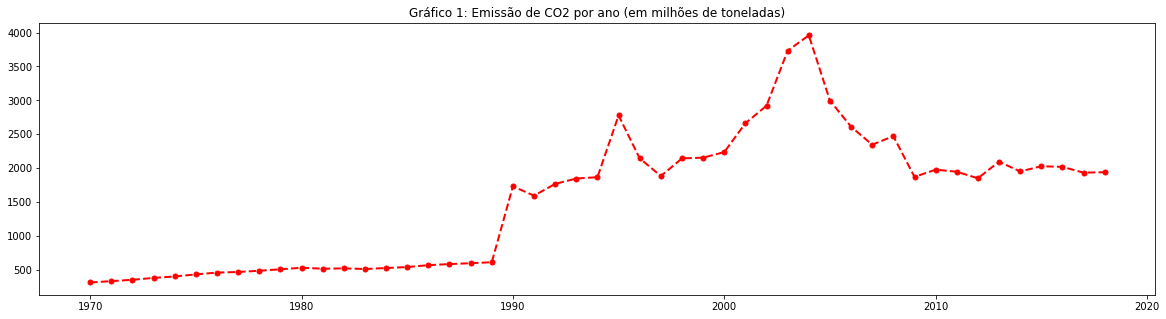

In [487]:
#Antes de qualquer coisa, vejamos o total de emissão de CO2 no Brasil
plt.figure(figsize=(20, 5))
plt.plot(data_emissoes['Valor/mi_t'], color = 'red',  marker='o',linestyle='dashed',linewidth=2, markersize=5)
plt.title('Gráfico 1: Emissão de CO2 por ano (em milhões de toneladas)')
plt.show();

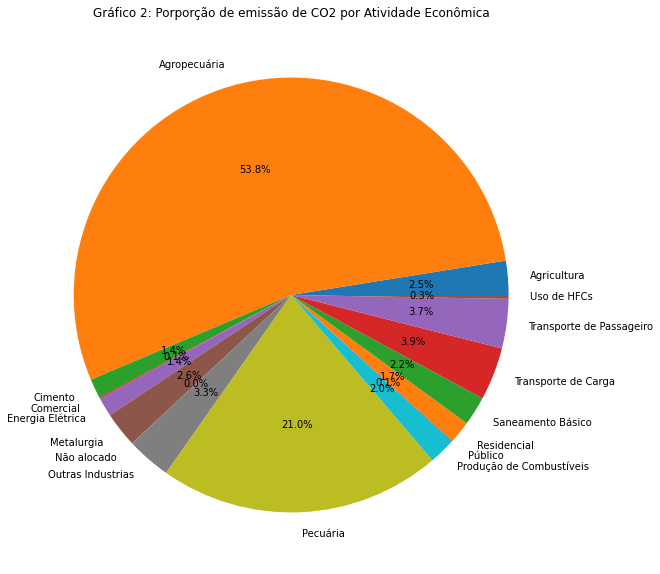

In [488]:
#Vejamos, no geral, o total de emissões ao longo dos anos por Atividade Econômica
data_cat_emissoes = pd.DataFrame(dados.groupby(['Categoria'])['Valor/mi_t'].sum())
data_cat_emissoes

plt.figure(figsize=(10, 10))
plt.pie(data_cat_emissoes['Valor/mi_t'], labels=data_cat_emissoes.index, autopct='%1.1f%%')
plt.title('Gráfico 2: Porporção de emissão de CO2 por Atividade Econômica')
plt.show()

*No Acordo de Paris, assinado em 2015, o Brasil se comprometeu a reduzir suas emissões em 37% até 2025 e em 43% até 2030, em relação ao índice de 2005.*


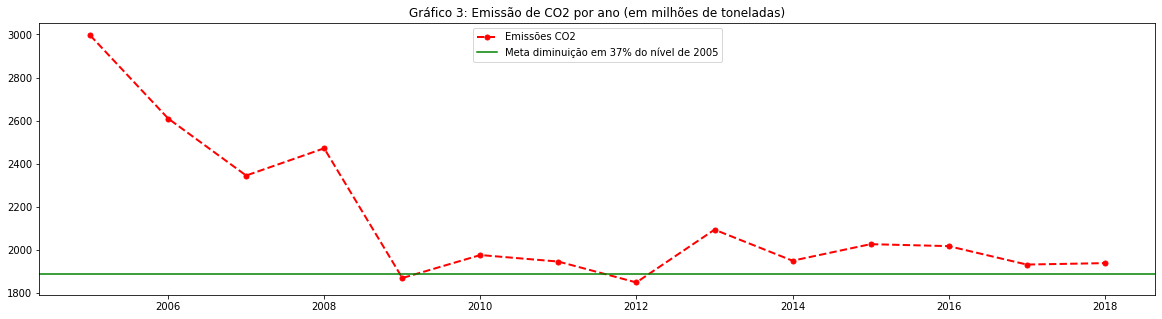

In [489]:
#Vejamos o mesmo gráfico resumido de 2005 em diante para observarmos o andamento das metas estabelecidas.
data_emissoes2 = data_emissoes.loc['2005':]
valor_2005 = data_emissoes2['Valor/mi_t'][0] - data_emissoes2['Valor/mi_t'][0] * 0.37

plt.figure(figsize=(20, 5))
plt.plot(data_emissoes2['Valor/mi_t'], color = 'red',  marker='o',linestyle='dashed',linewidth=2, markersize=5,label="Emissões CO2")
plt.title('Gráfico 3: Emissão de CO2 por ano (em milhões de toneladas)')
plt.axhline(valor_2005,color='green',label="Meta diminuição em 37% do nível de 2005")
plt.legend(loc='upper center')
plt.show();

In [490]:
print('Meta de diminuição de 37% do valor de emissão de CO2 em 2005:',valor_2005)
print('Média do histórico de emissão de CO2:',data_emissoes['Valor/mi_t'].mean())
print('Média do histórico (a partir de 1990) de emissão de CO2:',data_emissoes.loc['1990':]['Valor/mi_t'].mean())

Meta de diminuição de 37% do valor de emissão de CO2 em 2005: 1887.1964999999996
Média do histórico de emissão de CO2: 1531.8089795918365
Média do histórico (a partir de 1990) de emissão de CO2: 2256.541379310345


In [491]:
#Lista de categorias válidas
dados['Categoria'].unique()

array(['Agricultura', 'Agropecuária', 'Cimento', 'Comercial',
       'Energia Elétrica', 'Metalurgia', 'Não alocado',
       'Outras Industrias', 'Pecuária', 'Produção de Combustíveis',
       'Público', 'Residencial', 'Saneamento Básico',
       'Transporte de Carga', 'Transporte de Passageiro', 'Uso de HFCs'],
      dtype=object)

In [492]:
lista_categorias_validas = dados['Categoria'].unique()
lista_categorias_validas

array(['Agricultura', 'Agropecuária', 'Cimento', 'Comercial',
       'Energia Elétrica', 'Metalurgia', 'Não alocado',
       'Outras Industrias', 'Pecuária', 'Produção de Combustíveis',
       'Público', 'Residencial', 'Saneamento Básico',
       'Transporte de Carga', 'Transporte de Passageiro', 'Uso de HFCs'],
      dtype=object)

In [493]:
#Separando o DataFrame 'dados' em dfs separados por categoria
lim = dados['Categoria'].nunique()
dfs_categorias = []
x=0

for x in range(lim):
  dfs_categorias.append(dados[dados['Categoria']==lista_categorias_validas[x]])


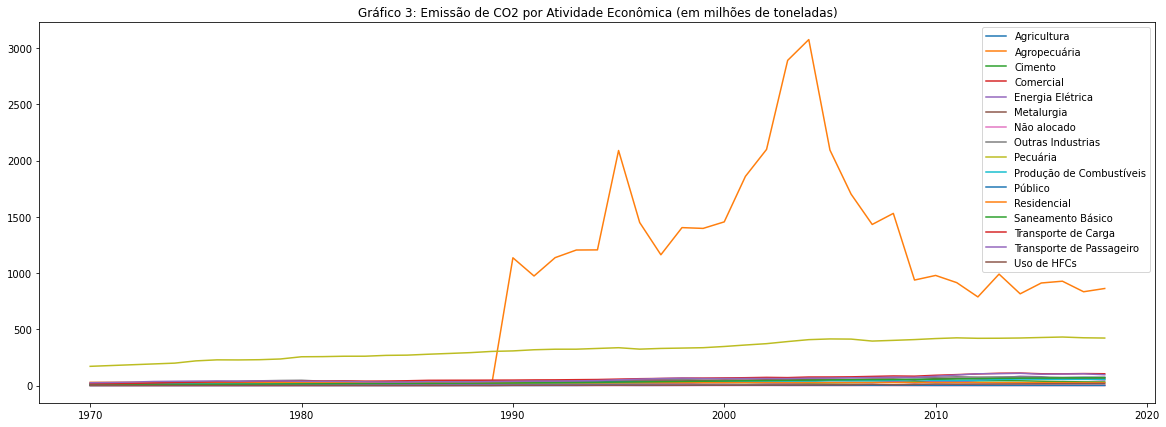

In [494]:
#Plotando todas as categorias
plt.figure(figsize=(20, 7))

for i in range(lim):
  plt.plot(dfs_categorias[i]['Data'],dfs_categorias[i]['Valor/mi_t'], label=lista_categorias_validas[i])
plt.title('Gráfico 3: Emissão de CO2 por Atividade Econômica (em milhões de toneladas)')
plt.legend();

#### Como podemos ver, a categoria "Agopecuária" distoa completamente dos níveis das demais categorias, sendo o principal emissor de CO2 no Brasil.

#### Além disto, por sua escala ser tão elevada, dificulta visualização das emissões dos demais. Por este motivo, iremos retirar "Agropecuária" para visualizar as demais.

In [495]:
# Iremos retirar "Agropecuária" para visualizar as demais
dfs_sem_agro = pd.DataFrame(dados[dados['Categoria'] != "Agropecuária"]).reset_index(drop = True)

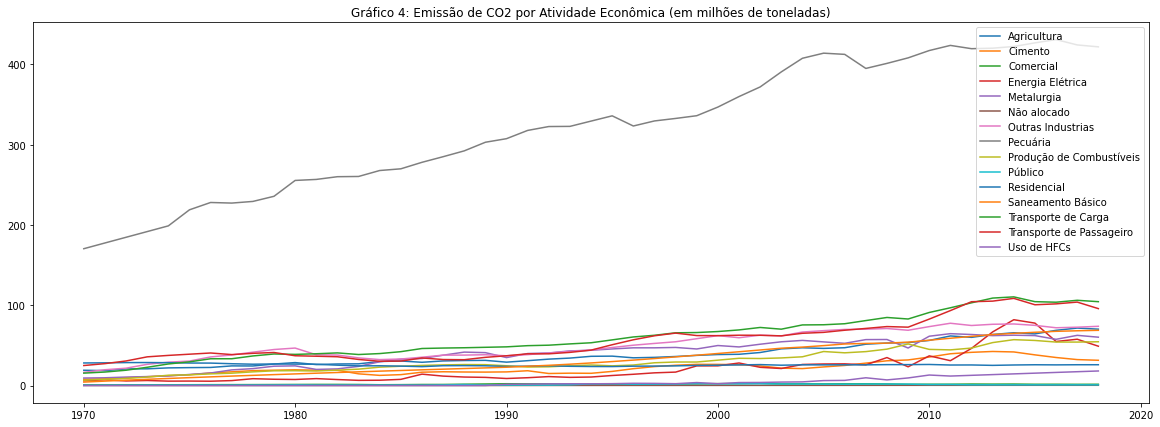

In [496]:
# Iremos retirar "Agropecuária" para visualizar as demais
lista_categorias_validas_sem_agro = dfs_sem_agro['Categoria'].unique()

lim = dfs_sem_agro['Categoria'].nunique()
dfs_categorias_sem_agro = []
x=0

for x in range(lim):
  dfs_categorias_sem_agro.append(dfs_sem_agro[dfs_sem_agro['Categoria']==lista_categorias_validas_sem_agro[x]])
  
plt.figure(figsize=(20, 7))

for i in range(lim):
  plt.plot(dfs_categorias_sem_agro[i]['Data'],dfs_categorias_sem_agro[i]['Valor/mi_t'], label=lista_categorias_validas_sem_agro[i])
plt.title('Gráfico 4: Emissão de CO2 por Atividade Econômica (em milhões de toneladas)')
plt.legend();


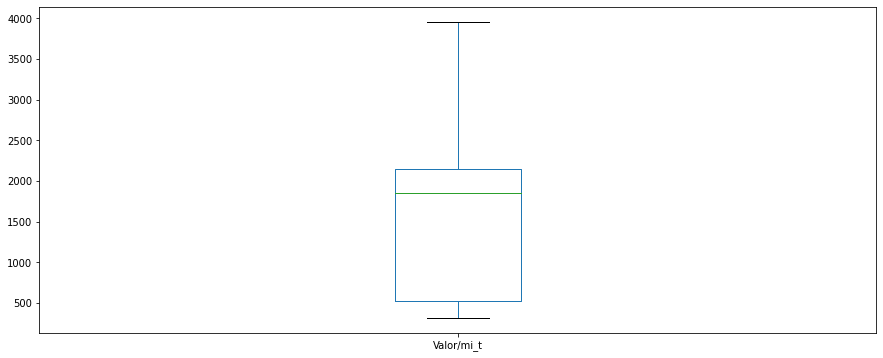

In [497]:
#Avaliando anos com picos de emissão fora do comum
data_emissoes['Valor/mi_t'].plot.box();

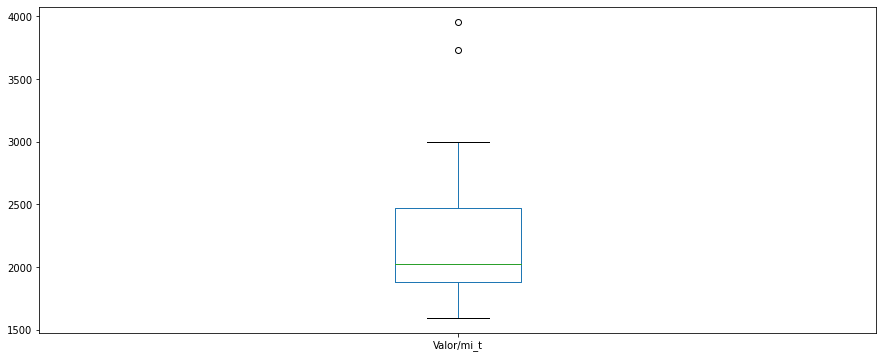

In [498]:
#Antes de 1990 os índices eram extremamente abaixo do que observamos no século XXI. Vejamos se existem outliers a partir de 1990:
data_emissoes['Valor/mi_t'].loc['1990':].plot.box();

In [499]:
#Identificando os anos com picos de emissão fora do comum:
#Apesar do boxplot com todos os dados não relatar outliers, pelo gráfico a partir de 1990 podemos identificar picos bem 'foca do comum'.
#Iremos considerar o valor em 3000 milhões de toneladas
data_emissoes[data_emissoes['Valor/mi_t'] > 3000]

,Valor/mi_t
Data,
2003-01-01,3732.55
2004-01-01,3959.10


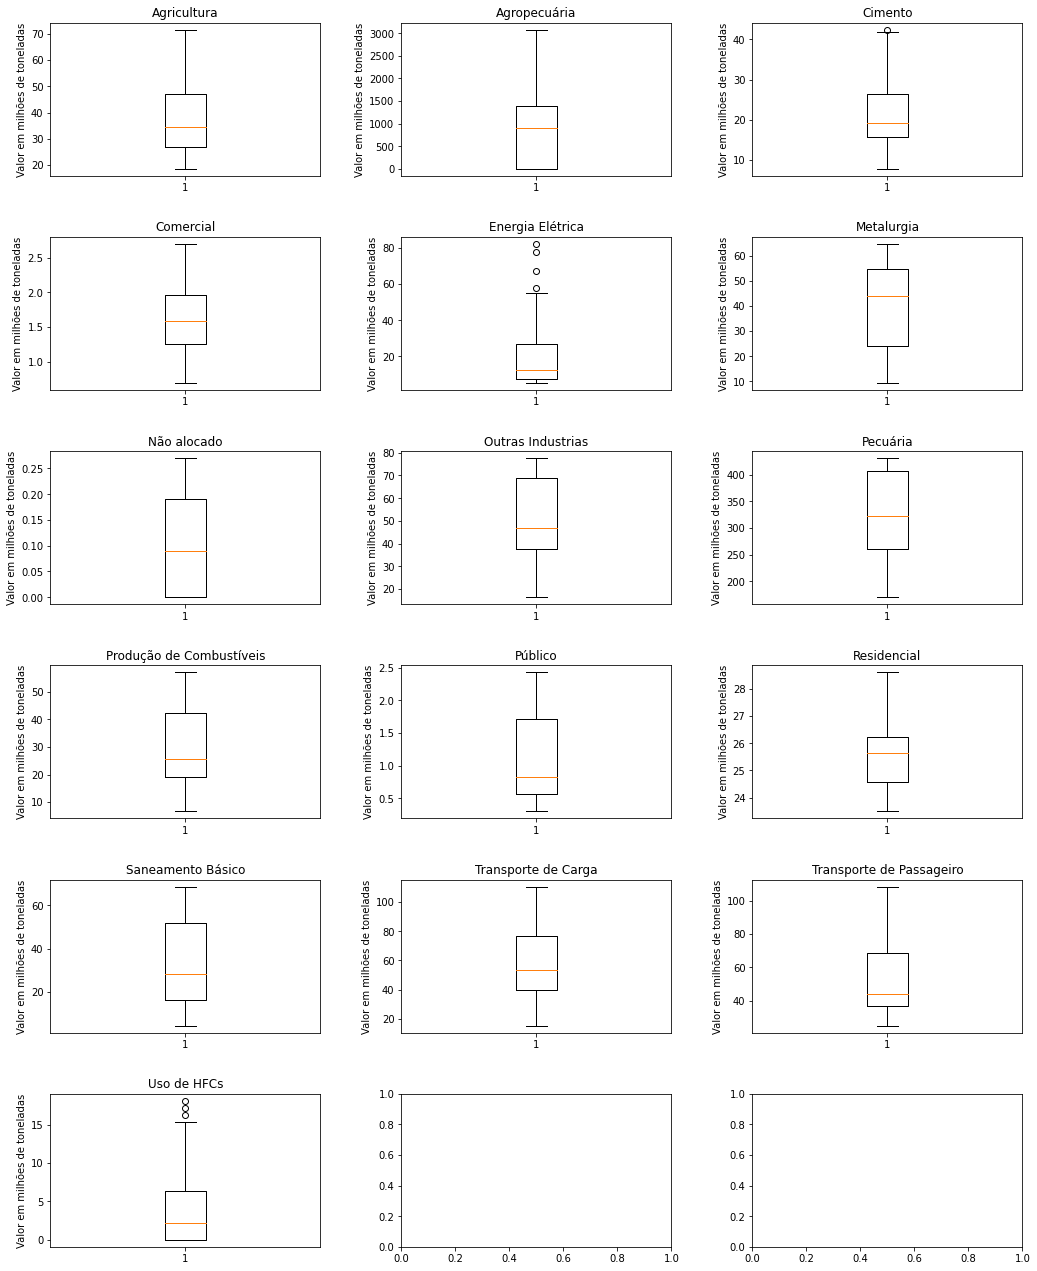

In [500]:
fig, axs = plt.subplots(6, 3, figsize=(15, 20))

axs[0, 0].boxplot(dfs_categorias[0]['Valor/mi_t'])
axs[0, 0].set_title(lista_categorias_validas[0])
axs[0, 0].set_ylabel('Valor em milhões de toneladas')

axs[0, 1].boxplot(dfs_categorias[1]['Valor/mi_t'])
axs[0, 1].set_title(lista_categorias_validas[1])
axs[0, 1].set_ylabel('Valor em milhões de toneladas')

axs[0, 2].boxplot(dfs_categorias[2]['Valor/mi_t'])
axs[0, 2].set_title(lista_categorias_validas[2])
axs[0, 2].set_ylabel('Valor em milhões de toneladas')

axs[1, 0].boxplot(dfs_categorias[3]['Valor/mi_t'])
axs[1, 0].set_title(lista_categorias_validas[3])
axs[1, 0].set_ylabel('Valor em milhões de toneladas')

axs[1, 1].boxplot(dfs_categorias[4]['Valor/mi_t'])
axs[1, 1].set_title(lista_categorias_validas[4])
axs[1, 1].set_ylabel('Valor em milhões de toneladas')

axs[1, 2].boxplot(dfs_categorias[5]['Valor/mi_t'])
axs[1, 2].set_title(lista_categorias_validas[5])
axs[1, 2].set_ylabel('Valor em milhões de toneladas')

axs[2, 0].boxplot(dfs_categorias[6]['Valor/mi_t'])
axs[2, 0].set_title(lista_categorias_validas[6])
axs[2, 0].set_ylabel('Valor em milhões de toneladas')

axs[2, 1].boxplot(dfs_categorias[7]['Valor/mi_t'])
axs[2, 1].set_title(lista_categorias_validas[7])
axs[2, 1].set_ylabel('Valor em milhões de toneladas')

axs[2, 2].boxplot(dfs_categorias[8]['Valor/mi_t'])
axs[2, 2].set_title(lista_categorias_validas[8])
axs[2, 2].set_ylabel('Valor em milhões de toneladas')

axs[3, 0].boxplot(dfs_categorias[9]['Valor/mi_t'])
axs[3, 0].set_title(lista_categorias_validas[9])
axs[3, 0].set_ylabel('Valor em milhões de toneladas')

axs[3, 1].boxplot(dfs_categorias[10]['Valor/mi_t'])
axs[3, 1].set_title(lista_categorias_validas[10])
axs[3, 1].set_ylabel('Valor em milhões de toneladas')

axs[3, 2].boxplot(dfs_categorias[11]['Valor/mi_t'])
axs[3, 2].set_title(lista_categorias_validas[11])
axs[3, 2].set_ylabel('Valor em milhões de toneladas')

axs[4, 0].boxplot(dfs_categorias[12]['Valor/mi_t'])
axs[4, 0].set_title(lista_categorias_validas[12])
axs[4, 0].set_ylabel('Valor em milhões de toneladas')

axs[4, 1].boxplot(dfs_categorias[13]['Valor/mi_t'])
axs[4, 1].set_title(lista_categorias_validas[13])
axs[4, 1].set_ylabel('Valor em milhões de toneladas')

axs[4, 2].boxplot(dfs_categorias[14]['Valor/mi_t'])
axs[4, 2].set_title(lista_categorias_validas[14])
axs[4, 2].set_ylabel('Valor em milhões de toneladas')

axs[5, 0].boxplot(dfs_categorias[15]['Valor/mi_t'])
axs[5, 0].set_title(lista_categorias_validas[15])
axs[5, 0].set_ylabel('Valor em milhões de toneladas')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

In [501]:
#Valor médio de emissão de CO2 por categoria
media_dados = dados.groupby('Categoria')['Valor/mi_t'].mean().sort_values(ascending=False)
media_dados

Categoria
Agropecuária                824.693469
Pecuária                    321.765918
Transporte de Carga          60.189592
Transporte de Passageiro     56.181837
Outras Industrias            50.487755
Metalurgia                   40.224694
Agricultura                  38.771633
Saneamento Básico            33.179592
Produção de Combustíveis     29.909388
Residencial                  25.661429
Cimento                      22.203265
Energia Elétrica             21.434286
Uso de HFCs                   4.339388
Comercial                     1.581224
Público                       1.084082
Não alocado                   0.101429
Name: Valor/mi_t, dtype: float64

In [502]:
#Rankear maiores emissores de CO2
ranking_dados = dados.groupby('Categoria')['Valor/mi_t'].sum().sort_values(ascending=False)
ranking_dados

Categoria
Agropecuária                40409.98
Pecuária                    15766.53
Transporte de Carga          2949.29
Transporte de Passageiro     2752.91
Outras Industrias            2473.90
Metalurgia                   1971.01
Agricultura                  1899.81
Saneamento Básico            1625.80
Produção de Combustíveis     1465.56
Residencial                  1257.41
Cimento                      1087.96
Energia Elétrica             1050.28
Uso de HFCs                   212.63
Comercial                      77.48
Público                        53.12
Não alocado                     4.97
Name: Valor/mi_t, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


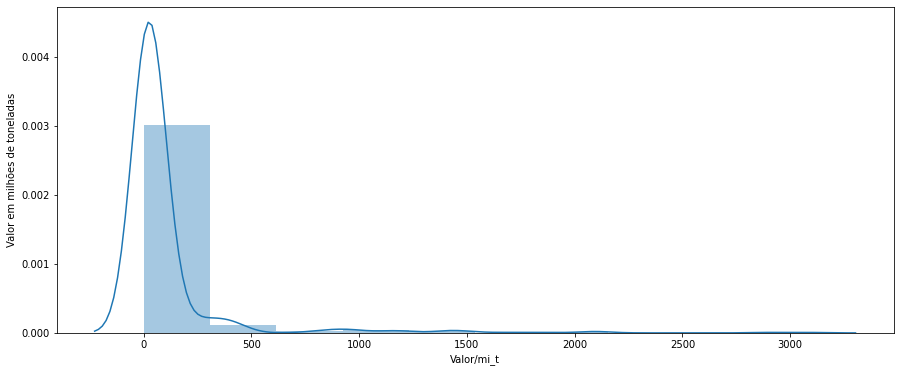

In [503]:
#Frequência de valores de emissão de CO2
ax = sns.distplot(dados['Valor/mi_t'], bins = 10)
ax.set_ylabel('Valor em milhões de toneladas');

In [504]:
# Porcentagem de emissão de CO2 somente de Agropecuária e Pecuária em relação a todas as categrias de emissão de CO2
print('A representatividade de Agricultura e Agropecuária na emissão de CO2 é:',(ranking_dados[0]+ranking_dados[1])/ranking_dados.sum())

A representatividade de Agricultura e Agropecuária na emissão de CO2 é: 0.7484349569882962


# Predição de Emissões

In [505]:
#Dividindo dataset de treino e teste
data_emissoes3 = pd.Series(dados.groupby('Data')['Valor/mi_t'].sum())
data_emissoes3
#70% treino
train_data = data_emissoes3.loc[:'2003']
#30% teste
test_data = data_emissoes3.loc['2004':]

## Estimando e Tratando Tendência e Sazonalidade

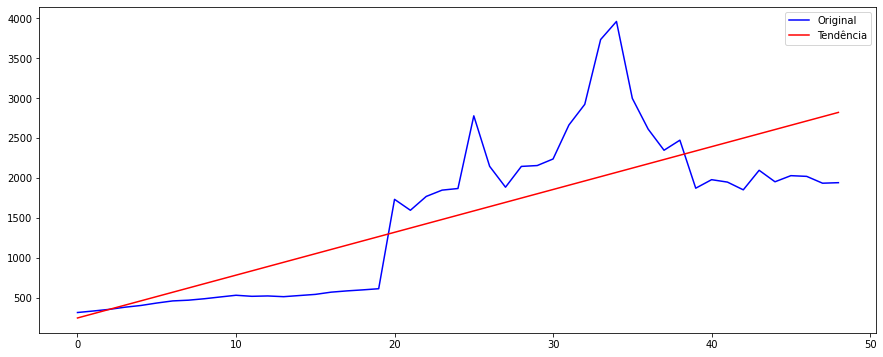

In [506]:
serie = data_emissoes3

#utilizando regressão linear para modelar tendência
from sklearn.linear_model import LinearRegression

X = [i for i in range(0, len(serie))] #indices
X = np.reshape(X, (len(X), 1))
y = serie
modelo = LinearRegression()
modelo.fit(X, y)

#estimando tendência
tendencia = modelo.predict(X)

#plotando tendência nos dados
plt.plot(serie.values, color='blue',label='Original')
plt.plot(tendencia,color='red', label='Tendência' )
plt.legend(loc='best')
plt.show()

In [507]:
#eliminando a tendência
serie_sem_tendencia = serie - tendencia

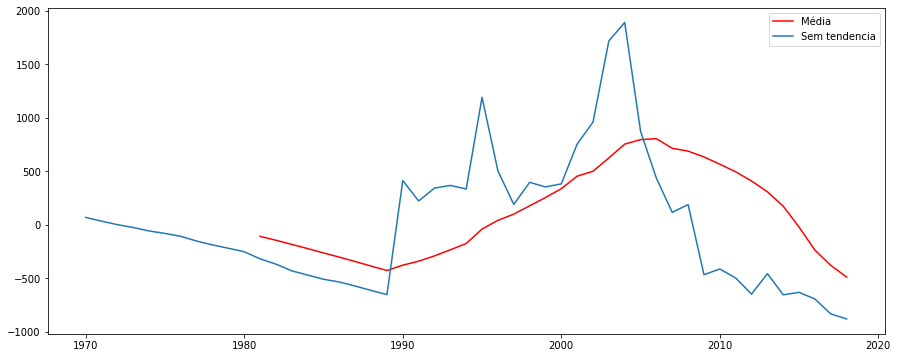

In [508]:
#Plotando os dados sem tendência
m_m = serie_sem_tendencia.rolling(window=12).mean()
mean = plt.plot(m_m, color='red',label='Média')
plt.plot(serie_sem_tendencia, label='Sem tendencia')
plt.legend(loc='best')
plt.show()

In [509]:
# fit polynomial
from numpy import polyfit

X = [i for i in range(0, len(serie_sem_tendencia))]
y = serie_sem_tendencia.values
degree = 50
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)

Coefficients: [-8.00868642e-71  1.08445946e-68 -1.56045635e-67 -1.97840913e-65
 -3.50036722e-64  2.37307759e-62  1.89916772e-60  5.46550781e-59
 -8.80075679e-58 -1.72742361e-55 -8.95103679e-54 -1.92282583e-52
  7.51003626e-51  9.34548356e-49  4.53456539e-47  9.04372134e-46
 -4.37532450e-44 -5.02611048e-42 -2.34310624e-40 -3.85604052e-39
  2.94834857e-37  2.81927469e-35  1.10895302e-33  3.11846412e-33
 -2.42424623e-30 -1.51857203e-28 -3.02241139e-27  1.92553354e-25
  1.73515603e-23  4.06160890e-22 -2.24979971e-20 -1.91648527e-18
 -1.80098451e-17  3.99401154e-15  1.43396346e-13 -7.06611434e-12
 -3.96000620e-10  1.83980579e-08  6.10367217e-07 -6.57260832e-05
  2.37724555e-03 -5.08841410e-02  7.23546073e-01 -7.09147609e+00
  4.81396526e+01 -2.22642784e+02  6.75266710e+02 -1.25316808e+03
  1.25006489e+03 -5.24202085e+02  6.68705357e+01]


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [510]:
curva = []
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curva.append(value)

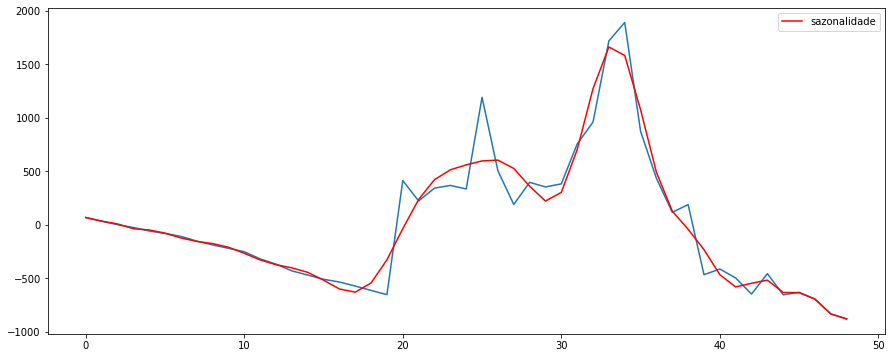

In [511]:
plt.plot(serie_sem_tendencia.values)
plt.plot(curva, color='red', label='sazonalidade')
plt.legend(loc='best')
plt.show()

In [512]:
#eliminando a sazonalidade
serie_sem_tendencia_sazonalidade = serie_sem_tendencia - curva

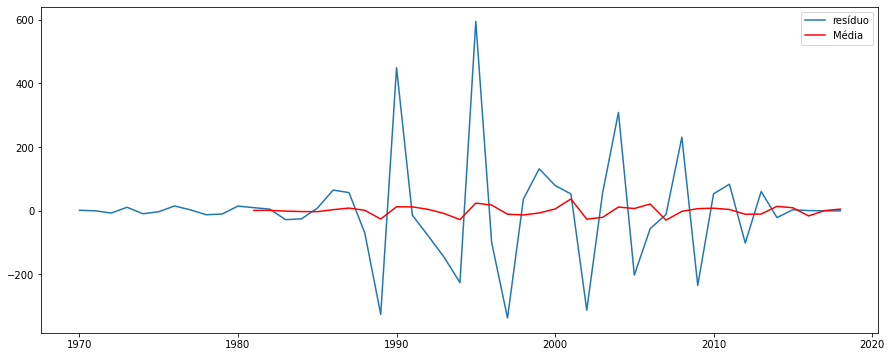

In [513]:
m_m = serie_sem_tendencia_sazonalidade.rolling(window=12).mean()
plt.plot(serie_sem_tendencia_sazonalidade, label='resíduo')
mean = plt.plot(m_m, color='red',label='Média')
plt.legend(loc='best')
plt.show()

## Avaliando Ruído

In [514]:
import statsmodels.graphics.tsaplots as smt

In [515]:
rcParams['figure.figsize'] = 15, 6

In [516]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


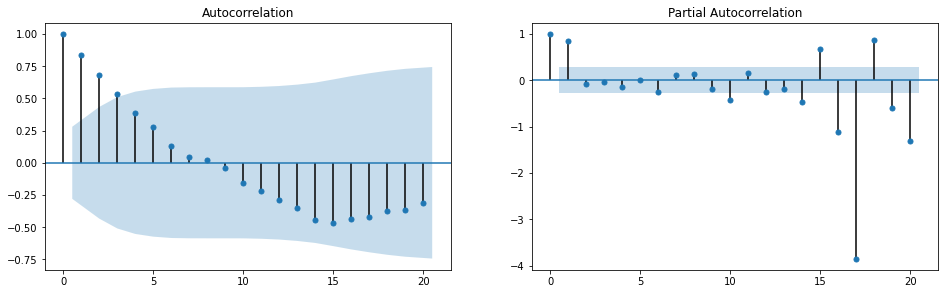

In [517]:
qtd_lag = 20
acf_pacf(serie_sem_tendencia, qtd_lag)

## ARIMA

### Modelagem

In [518]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [519]:
#parâmetros
p,d,q = 1, 1, 1

In [520]:
model = ARIMA(train_data.values, order=(p,d,q)).fit()

In [521]:
model.predict(typ='levels')

array([ 412.40035689,  446.63508823,  469.33093714,  495.53092022,
        518.00993294,  546.93256373,  573.97661441,  586.64768568,
        603.40769655,  624.60577582,  646.12012316,  639.58699047,
        641.65264723,  634.77908424,  644.95253699,  658.654577  ,
        683.9946186 ,  701.83268567,  715.48028442,  729.70972608,
       1636.43643606, 1713.03749124, 1855.44870625, 1948.42410781,
       1981.86050305, 2722.61574873, 2364.42122909, 2068.60260585,
       2223.76729398, 2268.41420377, 2341.47120125, 2699.85182469,
       2982.01725155])

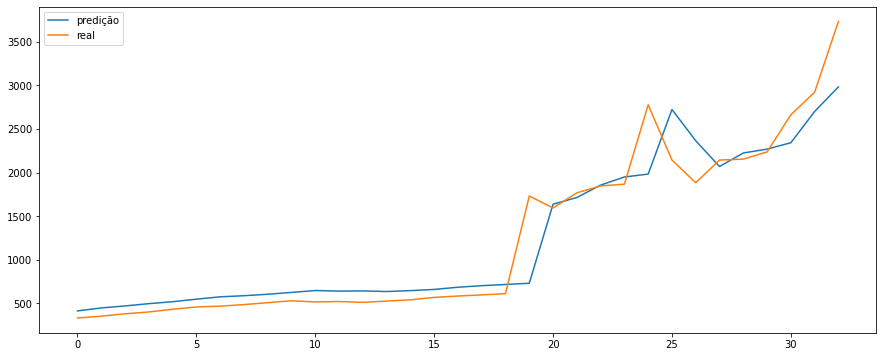

In [522]:
plt.plot(model.predict(typ='levels'), label = 'predição')
plt.plot(train_data.values[1:], label = 'real')
plt.legend()
plt.show()

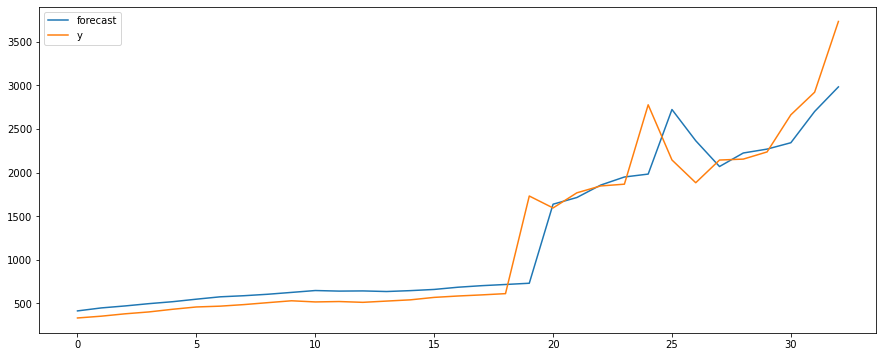

In [523]:
model.plot_predict();

In [524]:
train_predict = model.predict(typ='levels')
residuo = train_data.values[1:] - train_predict

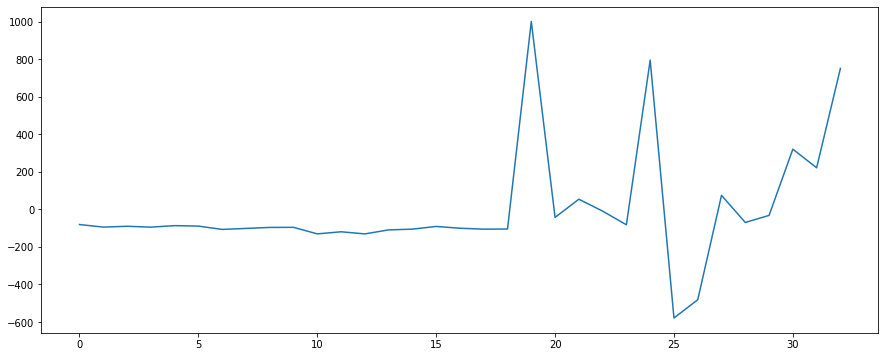

In [525]:
plt.plot(residuo);

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


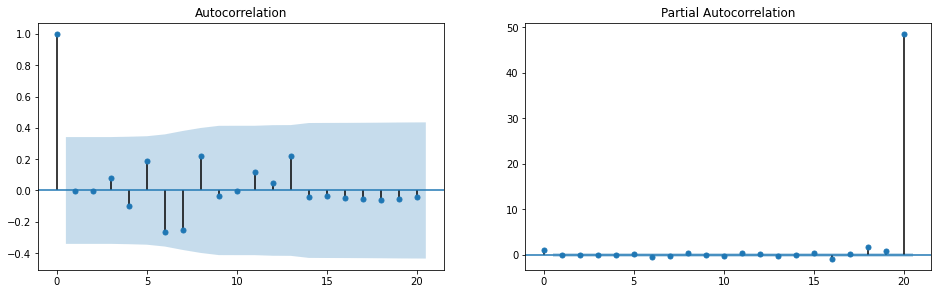

In [526]:
acf_pacf(residuo,20)

In [527]:
MAPE(train_data.values[1:],train_predict )

18.184689944107323

### Teste

In [528]:
predict_test = model.forecast(len(test_data))[0]

In [529]:
test_data.values

array([3959.1 , 2995.55, 2609.93, 2345.44, 2471.63, 1870.05, 1976.68,
       1946.44, 1849.57, 2094.39, 1950.39, 2027.09, 2018.07, 1932.59,
       1939.12])

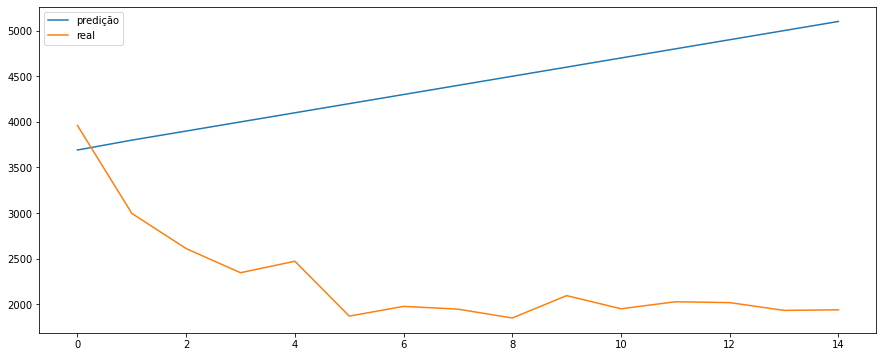

In [530]:
plt.plot(predict_test, label = 'predição')
plt.plot(test_data.values, label = 'real')
plt.legend()
plt.show()

In [531]:
MAPE(test_data.values,predict_test )

106.1370821915437

## KNN